### Load lib

In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import curve_fit

from data import *

plot_size = (12, 8)

### Helper Functions

In [2]:
def fix_date(df):
    df['time'] = df['time'].apply(lambda x:datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

def plot(plt, xlabel, ylabel="Count of Entries"):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

###  Read the data file

In [3]:
data = []

for i in range(0, 2):
    data.append(pd.read_csv(datasets_full[i] + ".csv"))

Check how many of the transfers failed

In [4]:
count_success = 0
count_failed = 0

print(np.unique(data[1]['transfer_history.state']))

for value in data[1]['transfer_history.state']:
    if(value == 'Completed'):
        count_success = count_success + 1
    else:
        count_failed = count_failed + 1

print("Completed transfers : " + str(count_success))
print("Failed transfers : " + str(count_failed))

['Completed' 'Failed']
Completed transfers : 12187
Failed transfers : 19


In [5]:
failed_qboxes = []
failed_time = []
failed_duration = []

for index, row in data[1].iterrows():
    if(row['transfer_history.state'] == "Failed"):
        failed_qboxes.append(row['transfer_history.qbox'])
        failed_time.append(row['time'])

temp = pd.DataFrame({'Failed Qboxes' : failed_qboxes, 'Failed Time' : failed_time})
print(temp)

                       Failed Qboxes               Failed Time
0   QBOX-4000-0000-1000-000000000001  2019-03-04T09:25:31.222Z
1   QBOX-4000-0000-1000-000000000002  2019-03-04T18:24:23.586Z
2   QBOX-4000-0000-1000-000000000006  2019-03-04T18:25:03.371Z
3   QBOX-4000-0000-1000-000000000005  2019-03-04T18:25:07.523Z
4   QBOX-4000-0000-1000-000000000001  2019-03-04T18:25:21.312Z
5   QBOX-4000-0000-1000-000000000002  2019-03-05T15:58:43.918Z
6   QBOX-4000-0000-1000-000000000002  2019-03-05T16:01:43.942Z
7   QBOX-4000-0000-1000-000000000002  2019-03-05T16:04:53.930Z
8   QBOX-4000-0000-1000-000000000002  2019-03-05T16:07:43.933Z
9   QBOX-4000-0000-1000-000000000004  2019-03-05T16:07:54.183Z
10  QBOX-4000-0000-1000-000000000002  2019-03-05T16:08:13.927Z
11  QBOX-4000-0000-1000-000000000002  2019-03-05T16:08:23.928Z
12  QBOX-4000-0000-1000-000000000002  2019-03-05T16:11:33.953Z
13  QBOX-4000-0000-1000-000000000006  2019-03-05T16:17:23.719Z
14  QBOX-4000-0000-1000-000000000001  2019-03-05T16:27:

In [6]:
count_up = 0
count_down = 0

print(np.unique(data[1]['transfer_history.transfer_direction']))

for value in data[1]['transfer_history.transfer_direction']:
    if(value == "Down"):
        count_down = count_down + 1
    else:
        count_up = count_up + 1

print("Up transfers : " + str(count_up))
print("Down transfers : " + str(count_down))

['Down' 'Up']
Up transfers : 476
Down transfers : 11730


Check if `transfer_history.cached_data_size` + `transfer_history.actually_transferred_size` = `transfer_history.transfer_size`

[4189, 2, 5564]


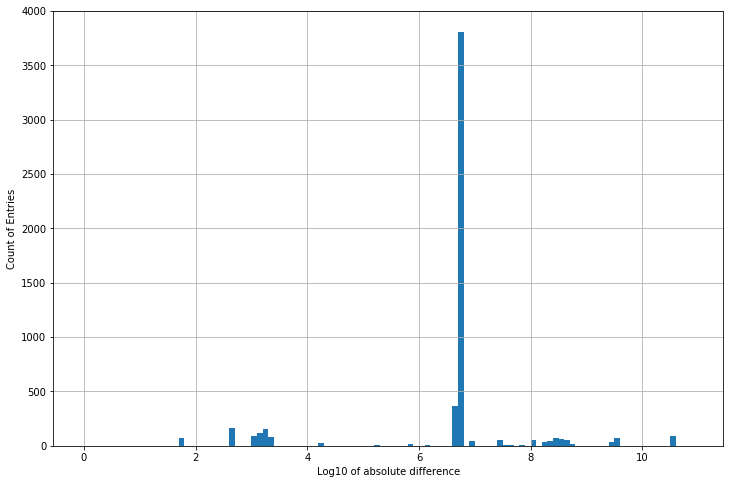

[5387, 13, 6806]


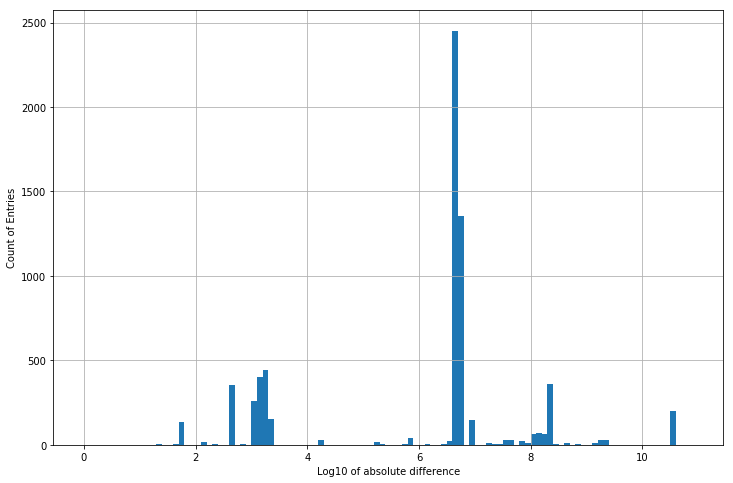

In [7]:
def check_transfer_data(temp):
    count_true = 0
    count_less = 0
    count_more = 0
    
    diff_per_list = []
    
    for index, row in temp.iterrows():
        a = row['transfer_history.cached_data_size']
        b = row['transfer_history.actually_transferred_size']
        c = row['transfer_history.transfer_size']
        
        if(a + b == c):
            count_true = count_true + 1
        else:   
            diff_per = abs(c - a - b)
            diff_per_list.append(diff_per)
            
            if(a + b < c):
                count_less = count_less + 1
            else:
                count_more = count_more + 1
    
    return [count_true, count_less, count_more], diff_per_list

for temp in data:
    stat, diff = check_transfer_data(temp)
    print(stat)
    
    plt.figure(figsize=plot_size)
    plt.hist(np.log10(diff), bins=np.arange(0, 11, 0.1))
    plot(plt, "Log10 of absolute difference")

In [8]:
data_mts = []

for i in range(0, 2):
    data_mts.append(np.array(data[i]["transfer_history.transfer_size"]))
    print("data[" + str(i) + "]")
    
    print("After removing negative and zeros : " + str(len(data_mts[i])))
    
    data_mts[i] = data_mts[i][data_mts[i] > 0.0]
    print("After removing negative and zeros : " + str(len(data_mts[i])))

data[0]
After removing negative and zeros : 9755
After removing negative and zeros : 7725
data[1]
After removing negative and zeros : 12206
After removing negative and zeros : 9504


In [9]:
data_mtts = []

for i in range(0, 2):
    data_mtts.append(np.array(data[i]["transfer_history.time_transfer_sec"]))
    print("data[" + str(i) + "]")
    
    print("After removing negative and zeros : " + str(len(data_mtts[i])))
    
    data_mtts[i] = data_mtts[i][data_mtts[i] > 0.0]
    print("After removing negative and zeros : " + str(len(data_mtts[i])))

data[0]
After removing negative and zeros : 9755
After removing negative and zeros : 9693
data[1]
After removing negative and zeros : 12206
After removing negative and zeros : 12099


### Plotting Function

In [10]:
def plot_hist(cut, temp, bins, name):
    
    # Plot the base histogram
    plt.figure(figsize=plot_size)
    plt.hist(temp, bins=np.arange(bins[0][0], bins[0][1], bins[0][2]))
    
    # Add the cutline
    plt.axvline((10.0 ** cut), color='k', linestyle='dashed')
    
    # Plot
    plot(plt, name)
    
    # Print stats related to the dotted line
    print("Points above the dotted line : " + str(sum(temp > (10.0 ** cut))))
    print("Total points in the dataset : " + str(len(temp)))

    # Get the log of the data
    temp = np.log10(temp)
    
    plt.figure(figsize=plot_size)
    
    # Now plot the logarithmic historgrams
    plt.hist(temp, bins=np.arange(bins[1][0], bins[1][1], bins[1][2]))
    
    # Calculate the bins for best fit
    bin_heights, bin_borders = np.histogram(temp, bins='auto')
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2
    
    # popt has the [mean, amplitude, deviation]
    # popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[max(bin_heights), 0, 0])
    
    # x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    # Add the guassian fit
    # lt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit', c='red')
    
    # Add the cutline
    plt.axvline(cut, color='k', linestyle='dashed')
    
    # Add the 99.9 percentile (3 sigma) deviation
    # plt.axvline(popt[0] + popt[2]*3, color='c', linestyle='dashed')
    # plt.axvline(popt[0] - popt[2]*3, color='c', linestyle='dashed')
    
    # Plot
    plot(plt, "Log of " + name)

### Transfer size

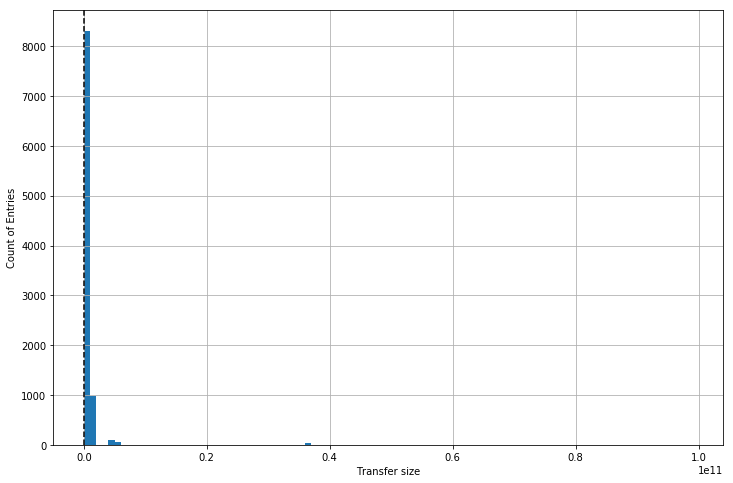

Points above the dotted line : 1657
Total points in the dataset : 9504


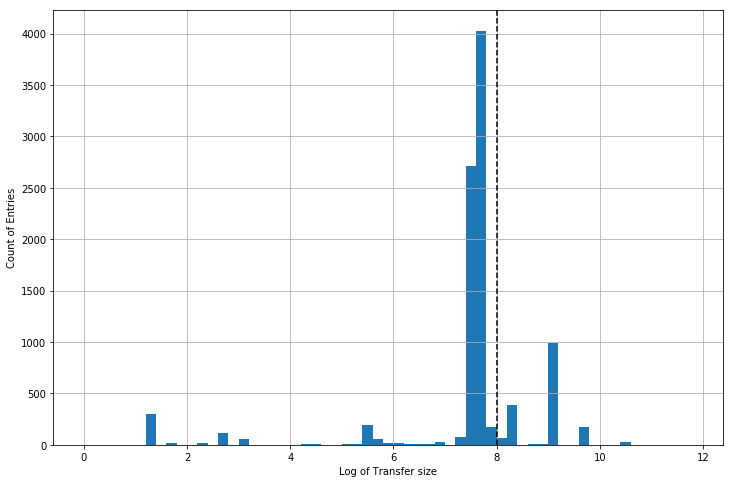

In [11]:
plot_hist(8, data_mts[1], [[0, 10**11, 10**9], [0, 12, 0.2]], "Transfer size")

### Transfer time

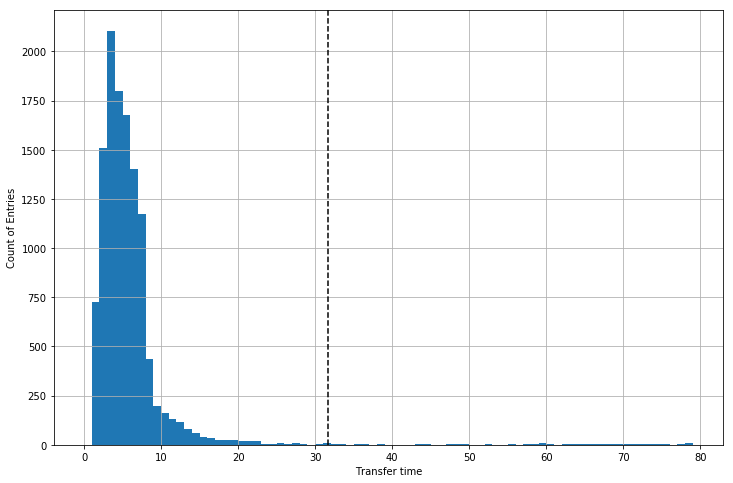

Points above the dotted line : 280
Total points in the dataset : 12099


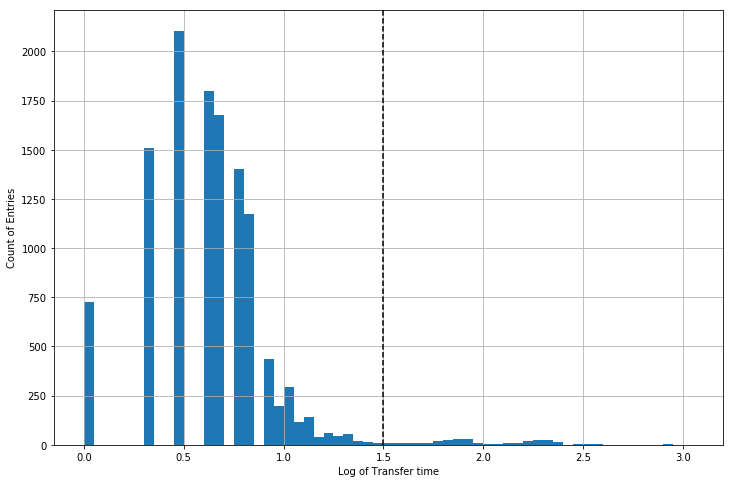

In [12]:
plot_hist(1.5, data_mtts[1], [[0, 8*(10**1), 1*(10**0)], [0, 3.1, 0.05]], "Transfer time")

In [13]:
data_json_id = []
data_json_size = []

# Open the dataset file
with open(dataset_json[0] + ".json", 'r') as file:

    # Iterate over every line (which is a json object)
    for cnt, line in enumerate(file):

        # Parse this object
        parsed = json.loads(line)

        data_json_id.append(parsed["id"])
        data_json_size.append(parsed["size"])
        
data_json_id = np.array(data_json_id)
data_json_size = np.array(data_json_size)

In [14]:
print("Length of data : " + str(len(data_json_id)))
print("Unique ids in data : " + str(len(np.unique(data_json_id))))

Length of data : 33258
Unique ids in data : 33258


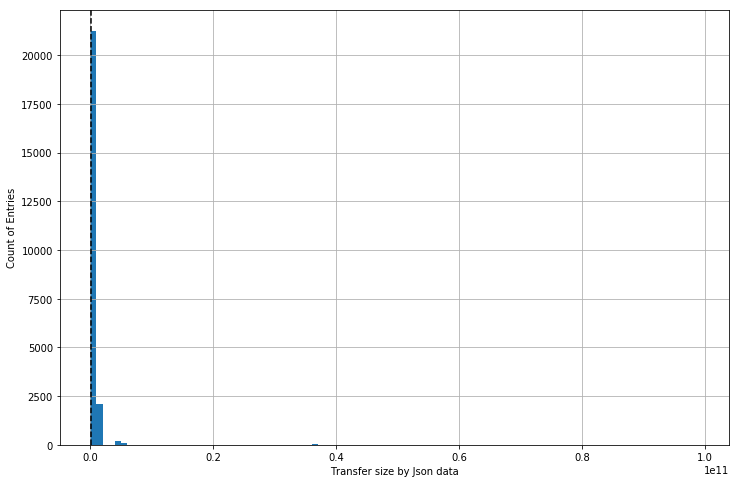

Points above the dotted line : 4457
Total points in the dataset : 23636


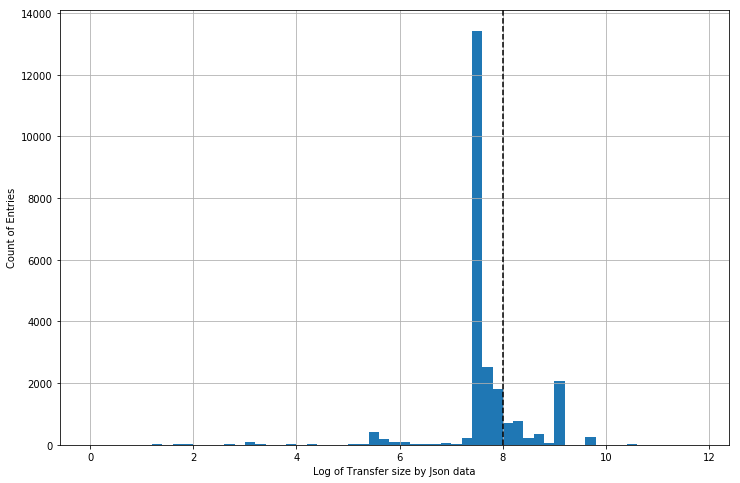

In [15]:
plot_hist(8, data_json_size[data_json_size > 0], [[0, 10**11, 10**9], [0, 12, 0.2]], "Transfer size by Json data")